## Q3) a-e

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import combinations

In [2]:
filname='Real estate valuation data set.xlsx'
df=pd.read_excel(filname)
df[:10]

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1


In [3]:
def RMS(y1,y2):
    #calculating RMS
    y1=np.transpose(y1)[0]
    y2=np.transpose(y2)[0]
    rms=(sum(((y1-y2)**2))/len(y1))**0.5
    return rms

In [4]:
data=np.array(df)
train_index=np.random.choice(np.array(range(414)),290, replace=False)        #test:train=30:70=124:290
train_set=np.array([data[i] for i in train_index])                          #random shuffling
test_set=[]
for i in range(414):
    if i not in train_index:
        test_set.append(data[i])
test_set=np.array(test_set)
train_X=train_set[:,1:7]
train_Y=np.transpose(np.array([train_set[:,-1]]))
test_X=test_set[:,1:7]
test_Y=np.transpose([test_set[:,-1]])                                #ground_truth
reg = LinearRegression().fit(train_X,train_Y)                        #linear regression training 
Y_pred=reg.predict(test_X)
print('Test data RMSE:',RMS(test_Y,Y_pred))
print('Train data RMSE:',RMS(train_Y,reg.predict(train_X)))

Test data RMSE: 8.218029379216116
Train data RMSE: 9.061544403132062


In [5]:
reg.coef_[0]     #regression coefficients

array([ 5.04960139e+00, -2.32880142e-01, -5.14215729e-03,  9.03148484e-01,
        2.24941772e+02, -5.49527968e+01])

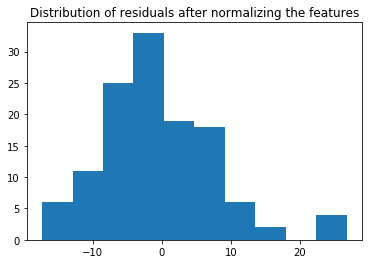

In [6]:
plt.hist(np.transpose(test_Y-Y_pred)[0])
plt.title("Distribution of residuals after normalizing the features")
plt.show()

The plot is normally distributed. Hence, the frequency of residual values close to zero is high and rest is low. Hence, suggesting the model is linear

In [7]:
#normalizing features to range [0,1]
train_X1=train_X / train_X.max(axis=0)
test_X1=test_X / test_X.max(axis=0)
reg1=LinearRegression().fit(train_X1,train_Y)                        #linear regression training 
Y_pred1=reg1.predict(test_X1)
print('Test set RMSE:',RMS(test_Y,Y_pred1))
print('Train set RMSE:',RMS(train_Y,reg1.predict(train_X1)))

Test set RMSE: 8.735989423823138
Train set RMSE: 9.061544403131945


In [8]:
reg1.coef_[0]     #regression coefficients after normalizing

array([ 1.01677932e+04, -1.02001502e+01, -3.28906932e+01,  9.03148484e+00,
        5.62682620e+03, -6.68040654e+03])

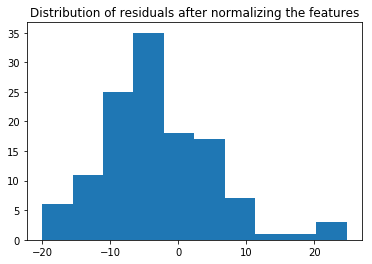

In [9]:
plt.hist(np.transpose(test_Y-Y_pred1)[0])
plt.title("Distribution of residuals after normalizing the features")
plt.show()

## Feature Selection by brute force

In [10]:

feature=range(6)
tmp_rmse=float('inf')
opt_feature=feature    #to store the optimum features indices, initialised to all features at begining
for i in range(1,5):
    feature_index=list(set(combinations(feature,i)))
    #print(feature_index)
    #feature_index=np.transpose(np.array(feature_index))[0]
    
    tmp_trainX=train_X[:,feature_index[0]]
    tmp_testX=test_X[:,feature_index[0]]
    for j in feature_index:
        tmp_trainX=train_X[:,j]
        tmp_testX=test_X[:,j]
        reg_tmp=LinearRegression().fit(tmp_trainX,train_Y)                        #linear regression training 
        Y_predtmp=reg_tmp.predict(tmp_testX)
        rmse_new=RMS(Y_predtmp,test_Y)
        if rmse_new<tmp_rmse:
            tmp_rmse=rmse_new
            opt_features=j
print("opt_features: ", opt_features)
print("rmse of best model: ",tmp_rmse)

opt_features:  (1, 2, 3, 4)
rmse of best model:  8.28944278524218


## Sequential Forward Selection

In [11]:
def SeqForSel(train_X,train_Y,test_X,test_Y):
    tmp_trainY=train_Y
    tmp_testY=test_Y

    rmse=float('inf')
    opt_features=[]
    tmp_trainX=np.array([[]])
    tmp_testX=np.array([[]])
    flag=0
    for i in range(6):
        if flag==1:
            break
        for j in range(6):
            if j not in opt_features:
                if len(tmp_trainX[0])==0:
                    tmp_=np.transpose([train_X[:,j]])
                    tmp__=np.transpose([test_X[:,j]])

                else:
                    tmp_=np.array([_ for _ in tmp_trainX])
                    tmp_=np.insert(tmp_,0,values=train_X[:,j],axis=1)
                    tmp__=np.array([_ for _ in tmp_testX])
                    tmp__=np.insert(tmp__,0,values=test_X[:,j],axis=1)

                reg_tmp=LinearRegression().fit(tmp_,tmp_trainY)                        #linear regression training 
                rmse_tmp=RMS(reg_tmp.predict(tmp__),tmp_testY)
                if rmse_tmp>rmse:
                    flag=1
                else:
                    flag=0
                    opt_features.append(j)
                    if len(tmp_trainX[0])==0:
                        tmp_trainX=np.transpose([train_X[:,j]])
                        tmp_testX=np.transpose([test_X[:,j]])

                    else:
                        tmp_trainX=np.insert(tmp_trainX,0,values=train_X[:,j],axis=1)
                        tmp_testX=np.insert(tmp_testX,0,values=test_X[:,j],axis=1)
                    rmse=rmse_tmp
    print("rmse : ",rmse)
    print("Optimum Features : ",opt_features)
SeqForSel(train_X,train_Y,test_X,test_Y)

rmse :  8.151943937431705
Optimum Features :  [0, 1, 2, 3, 4]
